# Deep Learning Portfolio 1

|Name|Github|Kaggle|
|----|------|------|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Michal Reszka-Gniecki|Ckires|...|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Visualiseren](#visualiseren)
- [Feature Engineering](#feature-engineering)
    - [Analysis](#analysis)
- [Modeling](#modeling)
    - [Fully-connected neuraal netwerk](#Model1)
    - [Convolutioneel neuraal netwerk from scratch](#Model2)
    - [Transfer learning](#Model3)
    - [Multimodaal mode](#Model4)
- [Results](#results)
    - [Overview](#overview)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)

In [2]:
!pip install keras_tuner
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from PIL import Image
from sklearn.preprocessing import StandardScaler
from keras_tuner import HyperParameters  as hp
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


## Data Overview

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_numeriek_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 1 Datasets/train.csv')
test_numeriek_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 1 Datasets/test.csv')

In [5]:
img_train_directory = "/content/drive/MyDrive/Colab Notebooks/Portfolio 1 Datasets/Train"
img_test_directory = "/content/drive/MyDrive/Colab Notebooks/Portfolio 1 Datasets/Test"

In [6]:
image_paths = tf.io.gfile.glob(img_train_directory + '/*.jpg')
images = []
for path in image_paths:
    image_raw = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_raw) # Aanpassen naar je bestandstype (bijv. png)
    images.append(image)

In [7]:
# Print de aantal foto's
print(len(images))

500


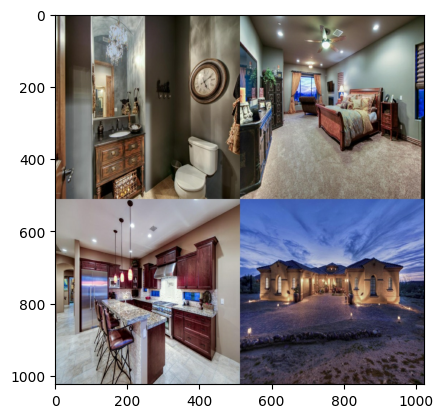

In [8]:
plt.imshow(images[495].numpy()) # Weergeeft de eerste afbeelding
plt.show()

In [9]:
display(train_numeriek_df)
display(test_numeriek_df.head())

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
0,1,4,4.0,4053,33.6968,-111.8892,869500
1,2,4,3.0,3343,34.8280,-119.0349,865200
2,3,3,4.0,3923,33.7669,-111.9182,889000
3,4,5,5.0,4022,33.7752,-111.7791,910000
4,5,3,4.0,4116,33.7669,-111.9182,971226
...,...,...,...,...,...,...,...
495,496,2,2.0,1257,35.6406,-120.7003,380000
496,497,4,2.0,2072,35.6406,-120.7003,429900
497,498,2,2.0,2213,35.6406,-120.7003,585000
498,499,3,2.5,1500,35.6406,-120.7003,319000


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
0,501,3,2.0,2330,35.6406,-120.7003
1,502,3,2.5,1339,35.6406,-120.7003
2,503,3,2.0,1472,35.6406,-120.7003
3,504,4,4.0,2681,35.6406,-120.7003
4,505,3,2.5,1935,33.8085,-117.9228


## Exploratory Data Analysis

###Datatype

In [10]:
train_numeriek_df.info()
test_numeriek_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   35 non-null     int64  
 1   Bedrooms   35 non-null     int64  
 2   Bathrooms  35 non-null     float64
 3   Area       35 non-null     int64  
 4   Latitude   35 non-null     float64
 5   Longitude  35 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 1.8 KB


### Kolombeschrijving

**House ID**: Unieke ID voor elk huis (int)  
**Bedrooms**: Het aantal slaapkamers in een huis (int)  
**Bathrooms**: Het aantal badkamers in een huis. Een halve badkamer betekent dan alleen 1 toilet of doucheruimte of wasbak. (float)  
**Area**: Het totale oppervlakte van het huis  
**Latitude**: Coordinaten (float)    
**Latitude**: Coordinaten (float)  
**Price**: De prijs van het huis (int)

### Verdeling van de data

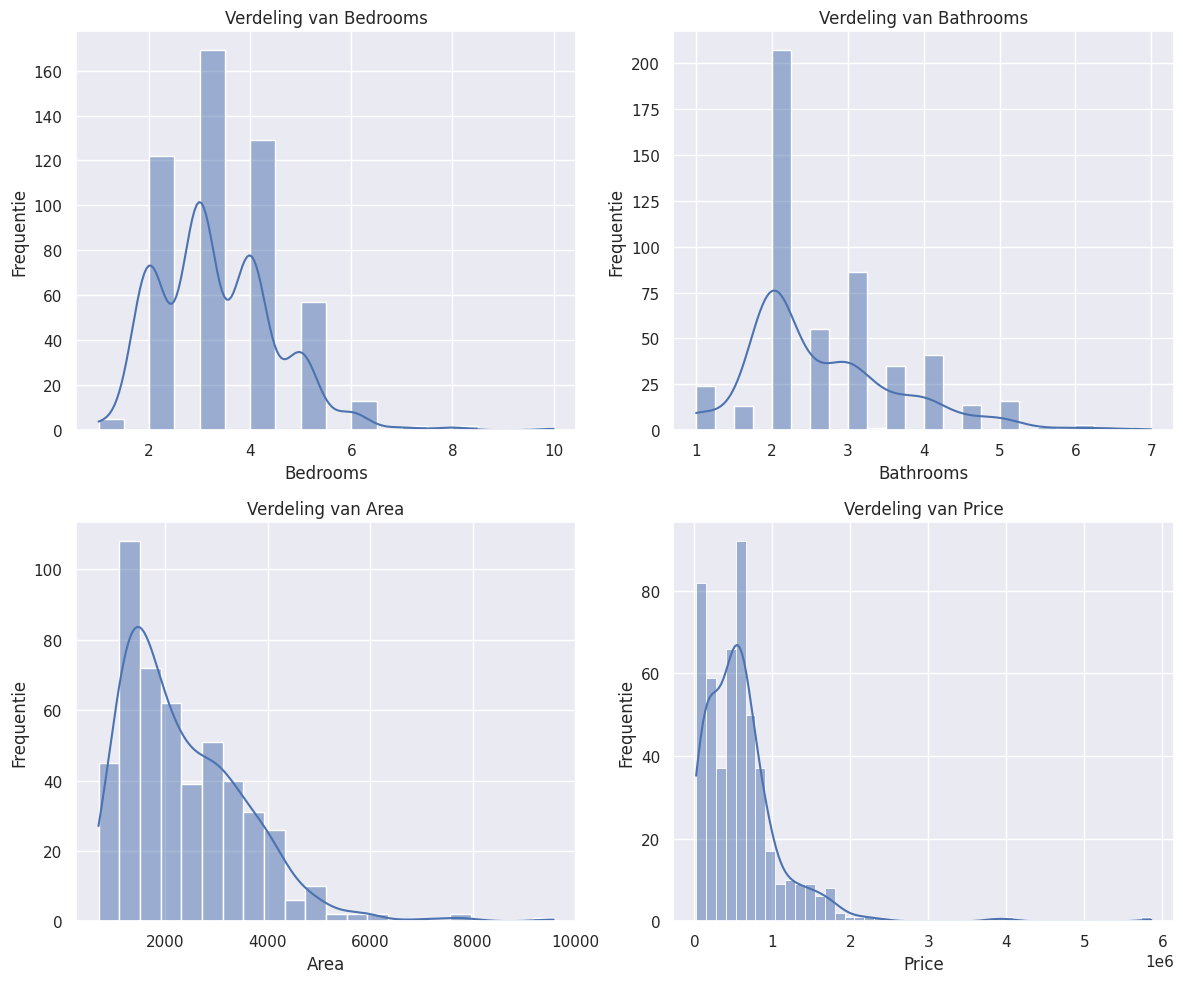

In [11]:
kolommen = ['Bedrooms', 'Bathrooms', 'Area', 'Price']

sns.set(style="darkgrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogrammen plotten in het raster
ax_index = 0
for rij in range(2):
    for kolom in range(2):
        sns.histplot(train_numeriek_df[kolommen[ax_index]], kde=True, ax=axes[rij, kolom])
        axes[rij, kolom].set_title(f'Verdeling van {kolommen[ax_index]}')
        axes[rij, kolom].set_xlabel(kolommen[ax_index])
        axes[rij, kolom].set_ylabel('Frequentie')
        ax_index += 1

plt.tight_layout()
plt.show()


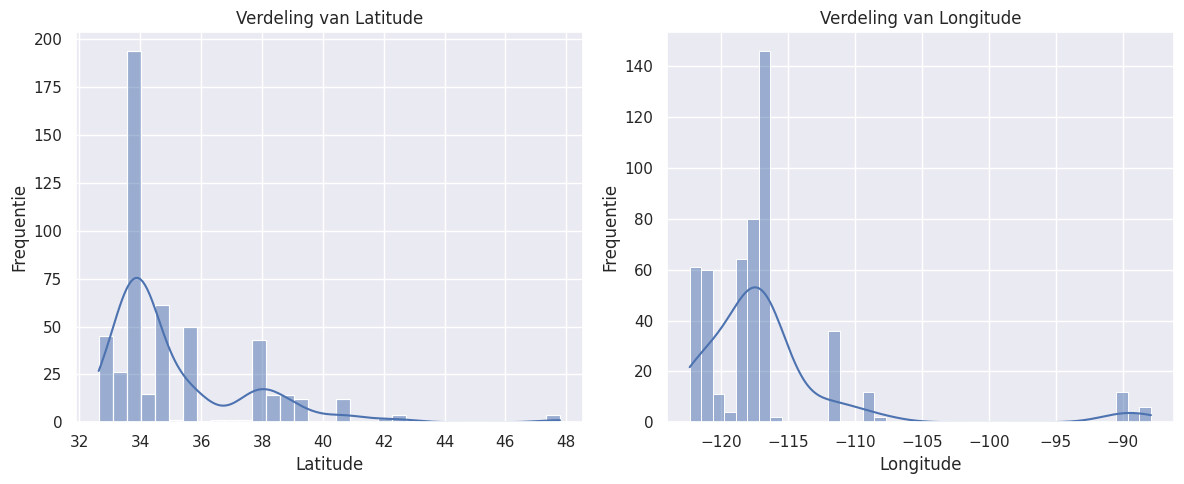

In [12]:
sns.set(style="darkgrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 rij, 2 kolommen

# Histogrammen plotten in het raster
ax_index = 0
for kolom in ['Latitude', 'Longitude']:
    sns.histplot(train_numeriek_df[kolom], kde=True, ax=axes[ax_index])
    axes[ax_index].set_title(f'Verdeling van {kolom}')
    axes[ax_index].set_xlabel(kolom)
    axes[ax_index].set_ylabel('Frequentie')
    ax_index += 1

plt.tight_layout()
plt.show()

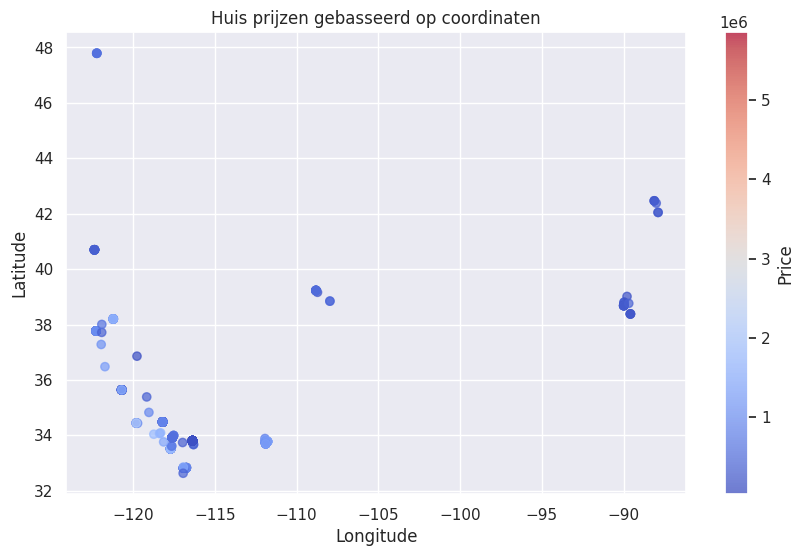

In [13]:
# Scatterplot maken
plt.figure(figsize=(10, 6))
scatter = plt.scatter(train_numeriek_df["Longitude"], train_numeriek_df["Latitude"], c=train_numeriek_df["Price"], cmap="coolwarm", alpha=0.7)

# Kleurbalk toevoegen
plt.colorbar(scatter, label="Price")

# Labels en titel
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Huis prijzen gebasseerd op coordinaten")

# Plot tonen
plt.show()

### Bevindingen

In deze grafiek worden de prijzen gevisualiseerd op basis van de coordinaten. Er blijkt dat er huizen helemaal links onder aan de duurdere kant liggen.

### Correlaties

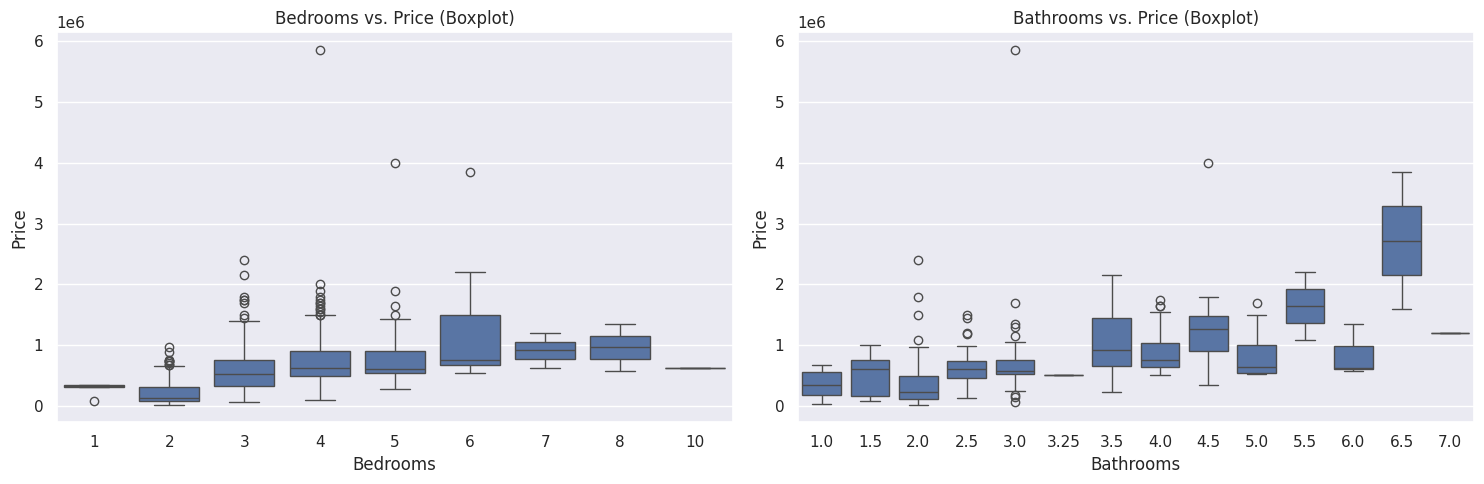

In [14]:
kolommen = ['Bedrooms', 'Bathrooms']

fig, axes = plt.subplots(1, len(kolommen), figsize=(15, 5))

# Boxplots plotten
for i, kolom in enumerate(kolommen):
    sns.boxplot(x=kolom, y='Price', data=train_numeriek_df, ax=axes[i])
    axes[i].set_title(f'{kolom} vs. Price (Boxplot)')
    axes[i].set_xlabel(kolom)
    axes[i].set_ylabel('Price')

plt.tight_layout()
plt.show()

#### Bevindingen

**Bedrooms**: Er zit geen sterke lineare verband in deze grafiek. Het blijkt dat huizen met slaapkamers van 1 tot 6 wel een lineare correlatie hebben, maar na 6 slaapkamers verschillen de prijzen niet meer.  
**Bathrooms**: Er blijkt geen lineare verband te zijn in deze grafiek. Maar er is wel te zien dat "halve" badkamers een hogere prijs hebben vergeleken met alleen complete badkamers.  

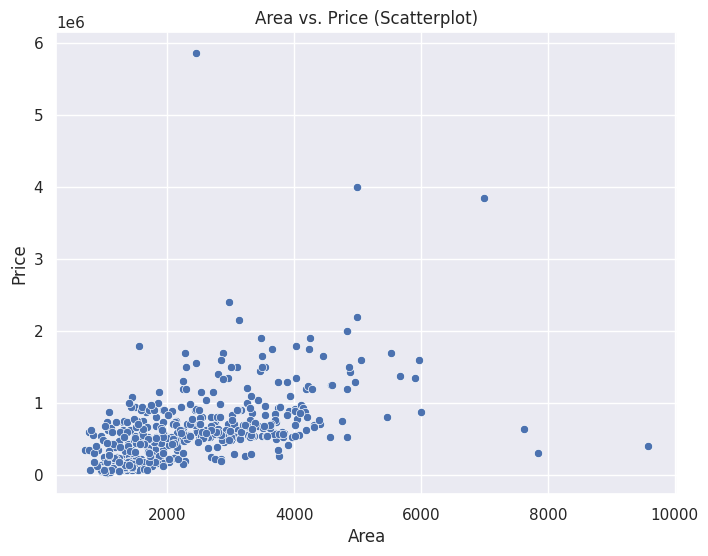

In [15]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Area', y='Price', data=train_numeriek_df)
plt.title('Area vs. Price (Scatterplot)')
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()

**Area**: In deze grafiek is er wel een relatief linear verband. Het blijkt dat huizen met een grotere oppervlakte wel duurder zijn.

### Conclusie  
Over het algemeen lijkt woonoppervlakte de sterkste invloed te hebben op de huisprijs, terwijl het effect van slaapkamers en badkamers niet zo duidelijk is.

### Visualiseren

## Feature Engineering

### Data Preparation

In [16]:
import tensorflow as tf

def df_to_dataset(dataframe, labels, shuffle=True, batch_size=64):
    '''
    Function to convert a pandas DataFrame into a TensorFlow dataset
    Parameters:
        dataframe (pandas DataFrame): Input features to be converted
        labels (Pandas Series): Input labels to be converted
        shuffle (boolean): Whether to shuffle the dataframe
        batch_size (int): Batch size to use when training
    Returns:
        ds: TensorFlow dataset object
    '''
    df = dataframe.copy()
    df = {key: value.values[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [17]:
X = train_numeriek_df.drop(['Price', 'House ID'], axis=1)
y = train_numeriek_df['Price']

# Get test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [20]:
X_train

,Bedrooms,Bathrooms,Area,Latitude,Longitude
486,2,2.0,1088,35.6406,-120.7003
246,5,3.0,3340,33.9208,-117.6096
346,2,2.0,1000,33.8082,-116.3713
480,3,2.0,1410,35.6406,-120.7003
329,3,2.0,2315,34.4835,-118.1959
...,...,...,...,...,...
3,5,5.0,4022,33.7752,-111.7791
133,7,7.0,3265,33.5145,-117.7084
236,4,3.0,3214,33.9208,-117.6096
87,4,3.5,3029,32.8282,-116.7543


In [21]:
train_ds = df_to_dataset(X_train, y_train, batch_size=32)
val_ds = df_to_dataset(X_val, y_val, shuffle=False, batch_size=32)
test_ds = df_to_dataset(X_test, y_test, shuffle=False, batch_size=32)

#### Normalize

In [22]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

### Combinatie maken van de Latitude en Longitude

Latitude en Longitude hebben individueel geen relevante informatie. Maar als ze gecombineerd worden, dan kan het heel nuttige informatie geven. In de EDA werd er duidelijk gezien dat in een bepaald gebied de prijs wel duurder is. Dus vandaar dat de coordinaten ook relevant kunnen zijn.

In [23]:
def get_bucketization_layer(name, dataset, num_bins=10):
    # Create a Bucketization layer for the feature.
    bucketizer = layers.Discretization(num_bins=num_bins)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    bucketizer.adapt(feature_ds)

    return bucketizer

In [24]:
def get_feature_crossing_layer(feature1, feature2, num_bins=100):
    # Create HashedCrossing() layer
    cross = layers.HashedCrossing(num_bins=num_bins)

    # Cross the two features using this layer
    feature_cross = cross([feature1, feature2])

    #  Convert this tensor to the same type as the numeric tensors, float32 in this case. Use tf.cast()
    # feature_cross = layers.Lambda(lambda x: tf.cast(x, dtype=tf.float32))(feature_cross)

    return feature_cross

In [35]:
# Create a list to store the raw data inputs
all_inputs = []

# Create a list to store the bucketized latitude and longitude
bucketized_locations = []

# Create a list to store the engineered features
engineered_features = []

# Standardize numerical features
for header in ['Bedrooms', 'Bathrooms', 'Area']:

    # Create input layer with shape (1,) and name=header
    numeric_col = keras.Input(shape=(1,), name=header)

    # Call normalization function with the correct arguments
    normalization_layer = get_normalization_layer(name=header, dataset=train_ds)

    # Apply the layer on the input column
    encoded_numeric_col = normalization_layer(numeric_col)

    # Append input column to list of inputs
    all_inputs.append(numeric_col)

    # Append engineered feature to list of engineered features
    engineered_features.append(encoded_numeric_col)

# Bucketize location features
for header in ['Latitude', 'Longitude']:

    # Create input layer with shape (1,) and name=header
    location_col = keras.Input(shape=(1,), name=header)

    # Call bucketization function with the correct arguments
    bucketization_layer = get_bucketization_layer(name=header, dataset=train_ds, num_bins=2)

    # Apply the layer on the input column
    bucketized_col = bucketization_layer(location_col)

    # Append input column to list of inputs
    all_inputs.append(location_col)

    # Append engineered feature to list of bucketized locations
    bucketized_locations.append(bucketized_col)

# Cross the bucketized latitude with bucketized longitude
crossed_location_feature = get_feature_crossing_layer(bucketized_locations[0], bucketized_locations[1], num_bins=4)
engineered_features.append(crossed_location_feature)

# Merge the list of engineered features into one vector via concatentation with tf.keras.layers.concatenate
all_features = tf.keras.layers.concatenate(engineered_features)

## Modeling

In [26]:
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / y_true)) * 100

### Fully-connected neuraal netwerk

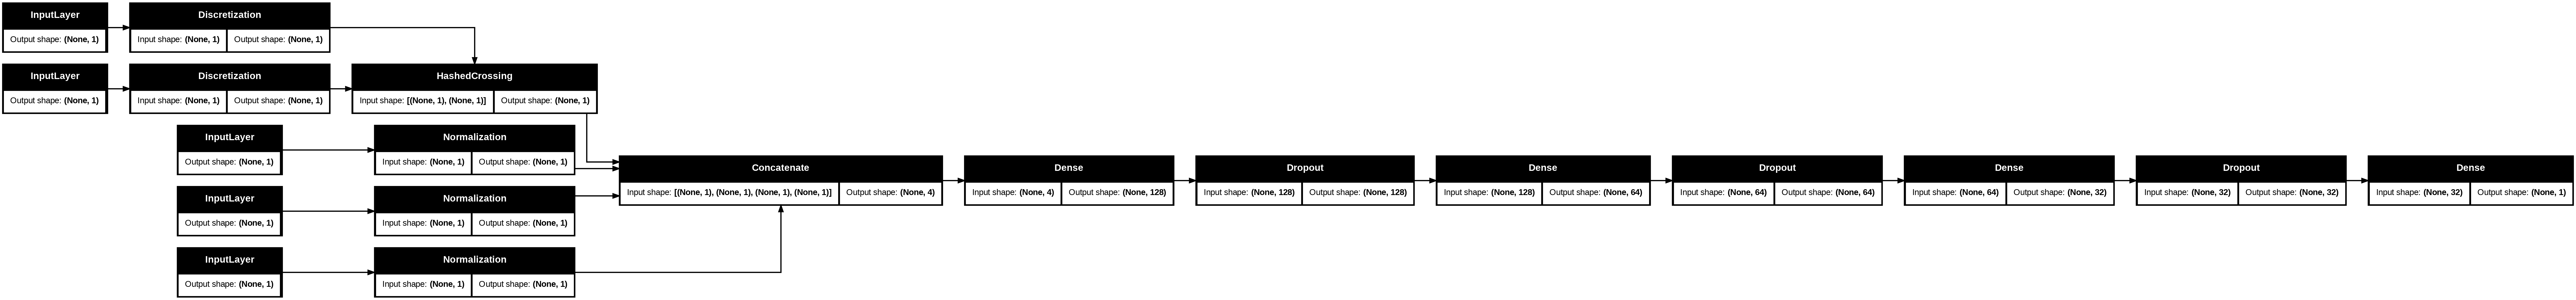

In [27]:
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l1(0.01))(all_features)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(1)(x)

model_eng = Model(inputs=all_inputs, outputs=output)

model_eng.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mape', metrics=['mape'])

plot_model(model_eng, show_shapes=True, rankdir="LR")

In [28]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_eng.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1, epochs=150, callbacks=[early_stopping])

# Evaluate
loss, mape = model_eng.evaluate(test_ds)
print("MAPE: ", mape)

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 100.4912 - mape: 99.9997 - val_loss: 100.2884 - val_mape: 99.9980
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 100.2362 - mape: 99.9964 - val_loss: 100.0999 - val_mape: 99.9870
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 100.0641 - mape: 99.9790 - val_loss: 99.9529 - val_mape: 99.9247
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 99.9100 - mape: 99.8829 - val_loss: 99.6933 - val_mape: 99.6710
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 99.5855 - mape: 99.5616 - val_loss: 98.8974 - val_mape: 98.8456
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 98.5717 - mape: 98.4917 - val_loss: 96.4966 - val_mape: 96.2915
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 95.2572 - mape: 94.9657 - val_loss: 89.7224 - val_mape: 89.1319
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 87.6555 - mape: 86.9548 - val_loss: 77.3848 - val_mape: 76.3949
Epoc

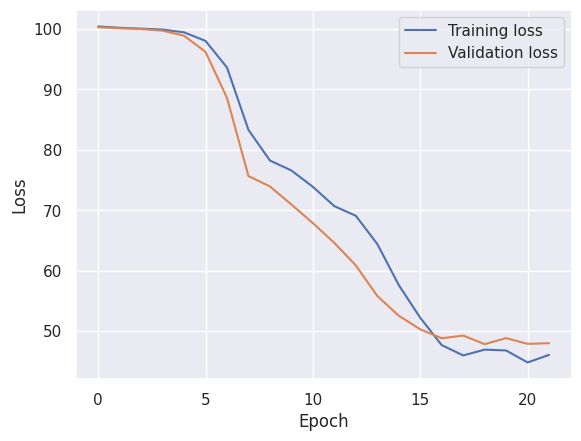

In [ ]:
# Plot de loss curves
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Hypertuning

In [ ]:
def build_model(hp):
    """Builds a Keras model with tunable hyperparameters."""

    # Define input layers as before
    all_inputs = []
    engineered_features = []
    bucketized_locations = []

    # ... (your existing code to create input layers and features)
        # Create a list to store the raw data inputs
    all_inputs = []

    # Create a list to store the bucketized latitude and longitude
    bucketized_locations = []

    # Create a list to store the engineered features
    engineered_features = []

    # Standardize numerical features
    for header in ['Bedrooms', 'Bathrooms', 'Area']:

        # Create input layer with shape (1,) and name=header
        numeric_col = keras.Input(shape=(1,), name=header)

        # Call normalization function with the correct arguments
        normalization_layer = get_normalization_layer(name=header, dataset=train_ds)

        # Apply the layer on the input column
        encoded_numeric_col = normalization_layer(numeric_col)

        # Append input column to list of inputs
        all_inputs.append(numeric_col)

        # Append engineered feature to list of engineered features
        engineered_features.append(encoded_numeric_col)

    # Bucketize location features
    for header in ['Latitude', 'Longitude']:

        # Create input layer with shape (1,) and name=header
        location_col = keras.Input(shape=(1,), name=header)

        # Call bucketization function with the correct arguments
        bucketization_layer = get_bucketization_layer(name=header, dataset=train_ds, num_bins=2)

        # Apply the layer on the input column
        bucketized_col = bucketization_layer(location_col)

        # Append input column to list of inputs
        all_inputs.append(location_col)

        # Append engineered feature to list of bucketized locations
        bucketized_locations.append(bucketized_col)

    # Cross the bucketized latitude with bucketized longitude
    crossed_location_feature = get_feature_crossing_layer(bucketized_locations[0], bucketized_locations[1], num_bins=4)
    engineered_features.append(crossed_location_feature)

    # Merge the list of engineered features into one vector via concatentation with tf.keras.layers.concatenate
    all_features = tf.keras.layers.concatenate(engineered_features)

    # Tune the number of units in the first Dense layer
    hp_units1 = hp.Int('units1', min_value=16, max_value=128, step=32)
    x = layers.Dense(units=hp_units1, activation="relu", kernel_regularizer=regularizers.l1(0.01))(all_features)
    x = layers.Dropout(0.3)(x)

    # Tune the number of units in the second Dense layer
    hp_units2 = hp.Int('units2', min_value=16, max_value=128, step=32)
    x = layers.Dense(units=hp_units2, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    # Tune the number of units in the thirds Dense layer
    hp_units3 = hp.Int('units3', min_value=16, max_value=128, step=32)
    x = layers.Dense(units=hp_units2, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    output = layers.Dense(1)(x)

    model = Model(inputs=all_inputs, outputs=output)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.005])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mape',
                  metrics=['mape'])

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mape', # Or 'val_loss' if you're optimizing for validation loss
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=3, # Number of times to train the model per hyperparameter combination
    directory='my_dir',
    project_name='intro_to_kt_2')

tuner.search_space_summary()

tuner.search(train_ds,
             epochs=150,
             validation_data=val_ds,
             callbacks=[early_stopping])

Trial 10 Complete [00h 00m 22s]
val_mape: 45.363234202067055

Best val_mape So Far: 45.104626973470054
Total elapsed time: 00h 03m 41s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, mape = best_model.evaluate(test_ds)
print("MAPE: ", mape)
print(best_model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 41.2892 - mape: 40.8374 
MAPE:  41.82115173339844


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Latitude (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Longitude (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Bedrooms (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Bathrooms (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Area (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ discretization            │ (None, 1)              │              0 │ Latitude[0][0]         │
│ (Discretization)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ discretization_1          │ (None, 1)              │              0 │ Longitude[0][0]        │
│ (Discretization)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 1)              │              3 │ Bedrooms[0][0]         │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 1)              │              3 │ Bathrooms[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 1)              │              3 │ Area[0][0]             │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hashed_crossing           │ (None, 1)              │              0 │ discretization[0][0],  │
│ (HashedCrossing)          │                        │                │ discretization_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 4)              │              0 │ normalization[0][0],   │
│                           │                        │                │ normalization_1[0][0], │
│                           │                        │                │ normalization_2[0][0], │
│                           │                        │                │ hashed_crossing[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │             80 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 80)             │          1,360 │ dropout[0][0]          │
├──────────────────────

 Total params: 8,010 (31.30 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 9 (48.00 B)

None


### Beste parameters
Beste hyperparameters na de hyperparameter tuning:
- 1e Dense layer: 16 neuronen
- 2e Dense Layer: 80 neuronen
- 2e Dense Layer: 80 neuronen  

Kaggle score: 0.6

### Multimodaal

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Latitude (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Longitude (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Bedrooms (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Bathrooms (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Area (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ discretization_4          │ (None, 1)              │              0 │ Latitude[0][0]         │
│ (Discretization)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ discretization_5          │ (None, 1)              │              0 │ Longitude[0][0]        │
│ (Discretization)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_6           │ (None, 1)              │              3 │ Bedrooms[0][0]         │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_7           │ (None, 1)              │              3 │ Bathrooms[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_8           │ (None, 1)              │              3 │ Area[0][0]             │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hashed_crossing_2         │ (None, 1)              │              0 │ discretization_4[0][0… │
│ (HashedCrossing)          │                        │                │ discretization_5[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 4)              │              0 │ normalization_6[0][0], │
│ (Concatenate)             │                        │                │ normalization_7[0][0], │
│                           │                        │                │ normalization_8[0][0], │
│                           │                        │                │ hashed_crossing_2[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rgb_input (InputLayer)    │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gray_input (InputLayer)   │ (None, 64, 64, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 128)            │            640 │ concatenate_3[0][0]    │
├──────────────────────

 Total params: 3,283,434 (12.53 MB)

 Trainable params: 3,283,425 (12.53 MB)

 Non-trainable params: 9 (48.00 B)

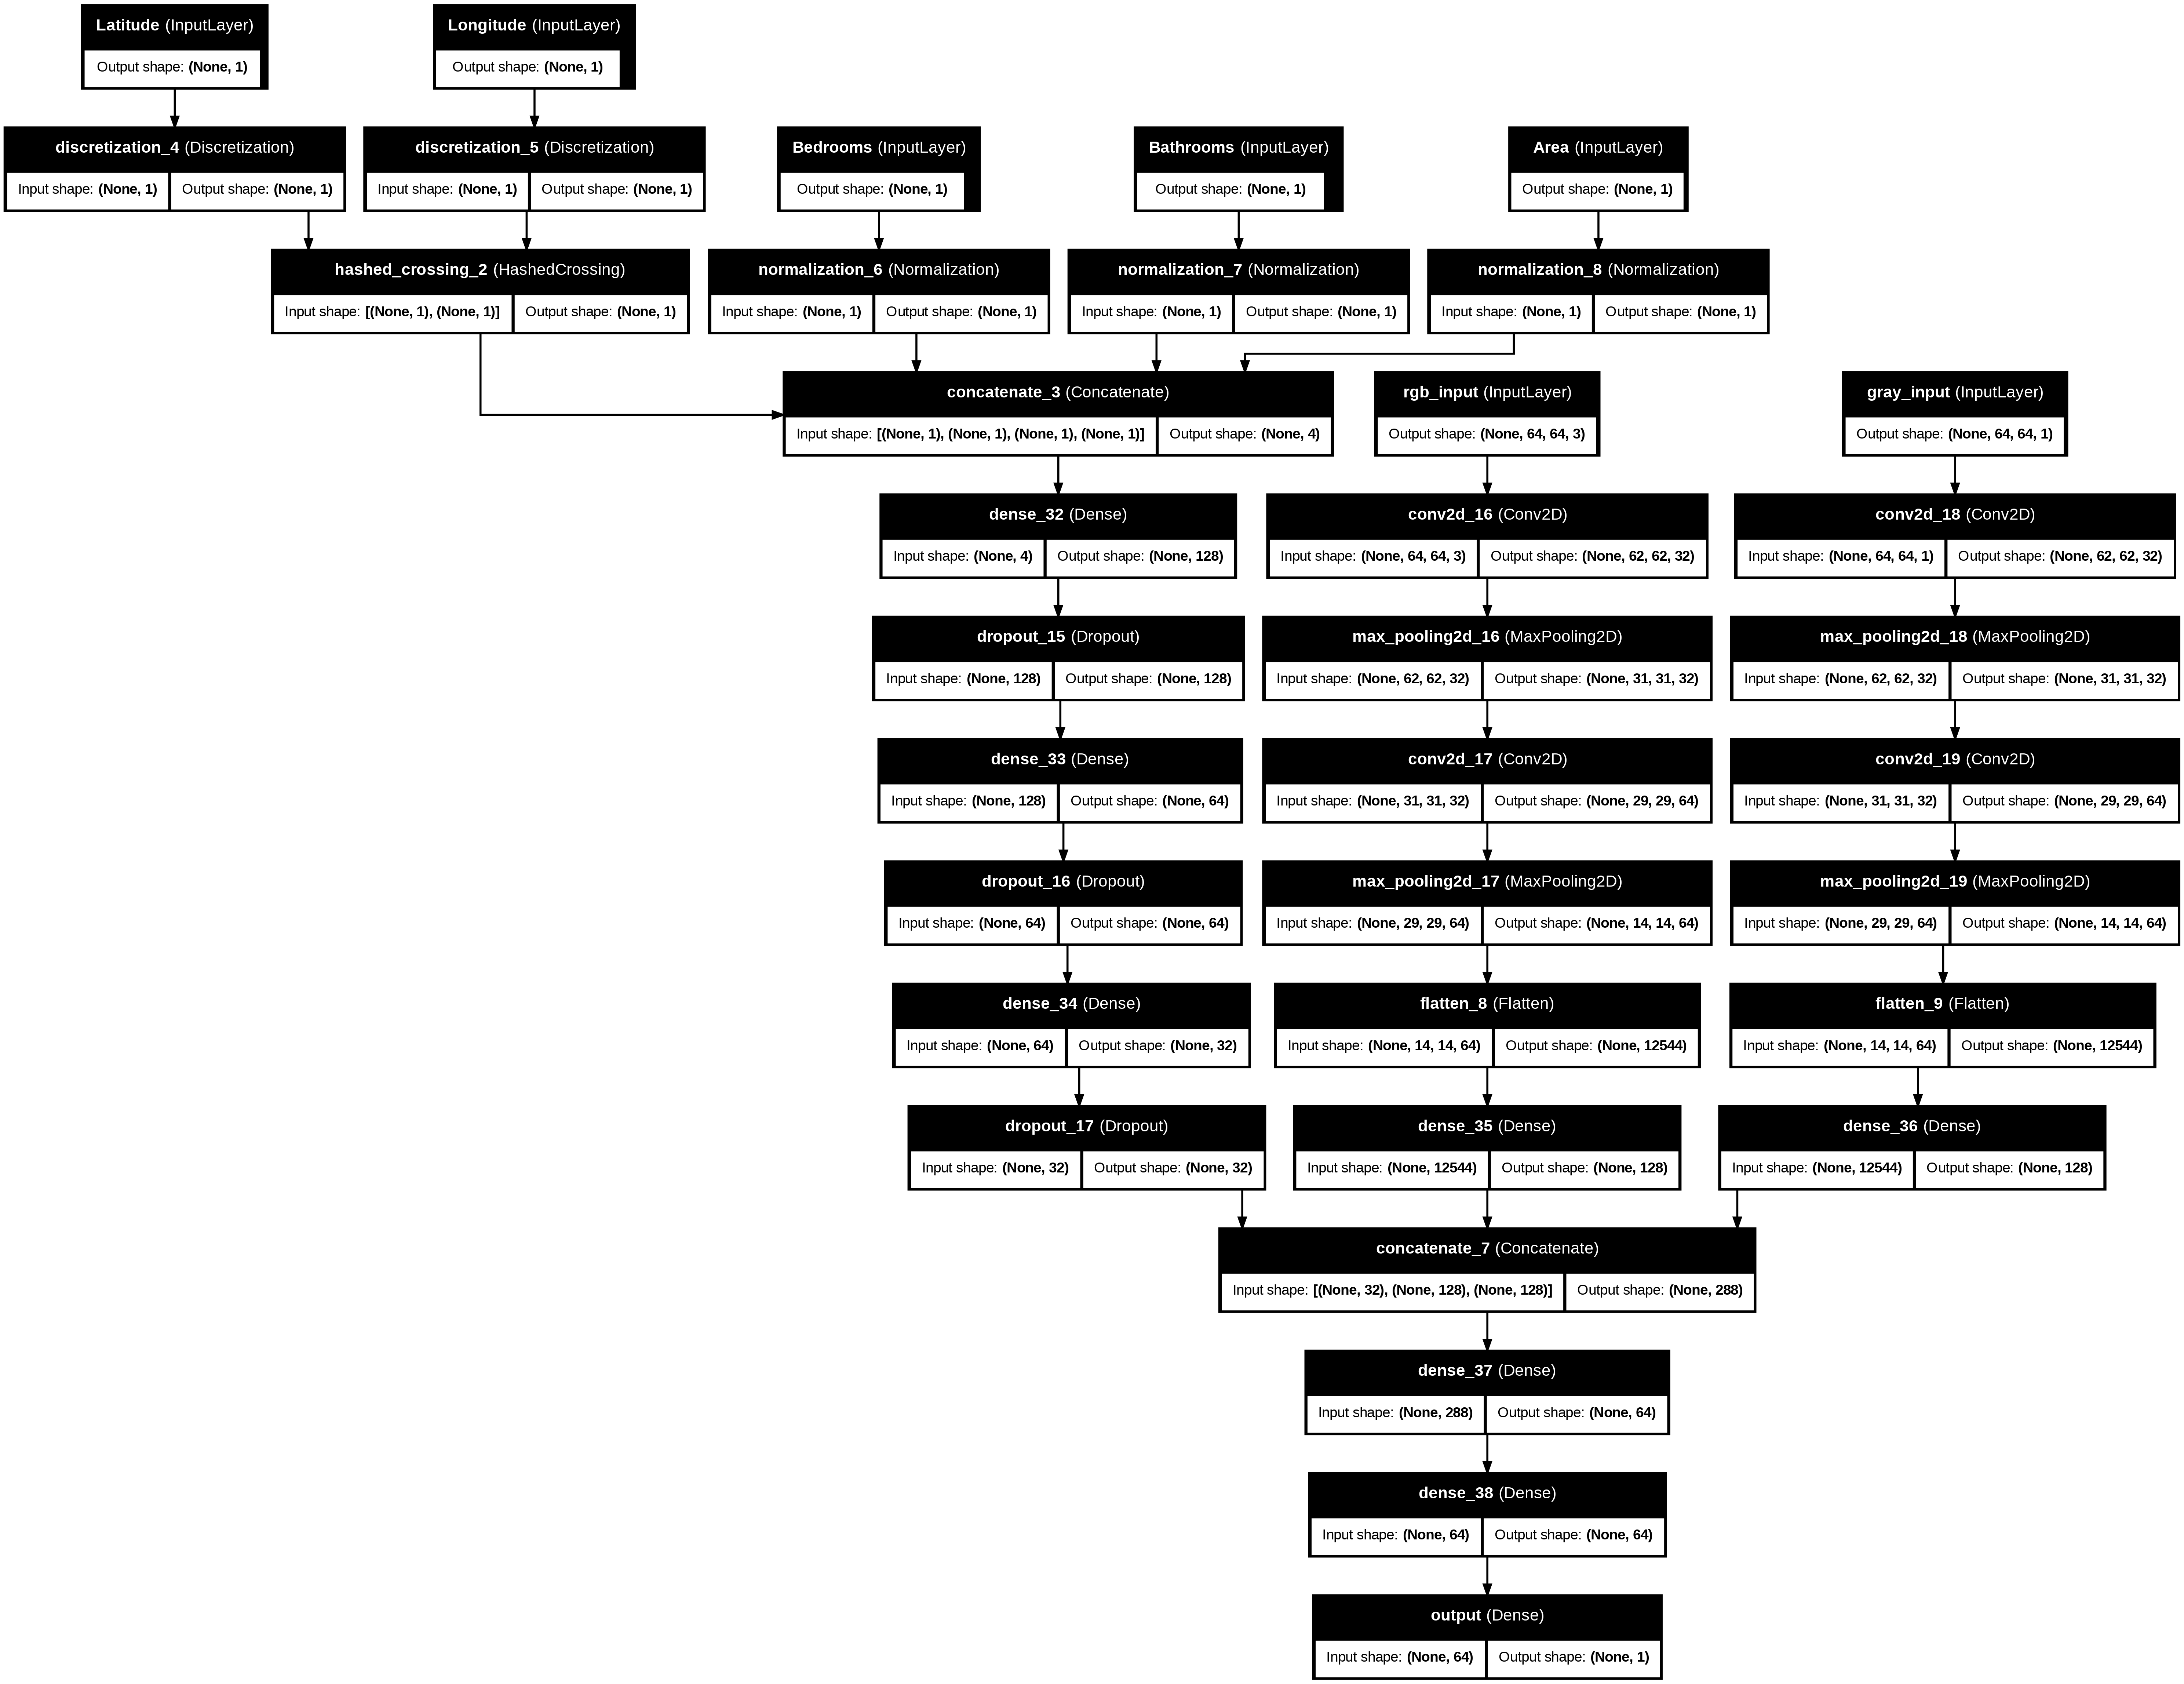

In [39]:
# multimodaal_train_df = train_numeriek_df.copy()

# df = train_numeriek_df.copy()

# Images omzetten naar arrays
def load_image_as_array(house_id, img_directory, target_size=(64, 64), mode='RGB'):
    """
    Loads an image for the given house_id from img_directory,
    converts it to the specified mode, and resizes it.
    """
    image_path = os.path.join(img_directory, f"{house_id}.jpg")
    if os.path.exists(image_path):
        image = Image.open(image_path).convert(mode)
        image = image.resize(target_size)
        image_array = np.array(image)
        # For grayscale images, add a channel dimension
        if mode == 'L':
            image_array = np.expand_dims(image_array, axis=-1)
        return image_array
    else:
        return None

# Prepare the data
multimodaal_train_df = train_numeriek_df.copy()
num_features = ['Bedrooms', 'Bathrooms', 'Area', 'Latitude', 'Longitude']

# Normalize target variable
multimodaal_train_df['Price'] = multimodaal_train_df['Price'] / multimodaal_train_df['Price'].max()

# Load images
multimodaal_train_df['Image_RGB'] = multimodaal_train_df['House ID'].apply(
    lambda x: load_image_as_array(x, img_train_directory, target_size=(64, 64), mode='RGB'))
multimodaal_train_df['Image_Gray'] = multimodaal_train_df['House ID'].apply(
    lambda x: load_image_as_array(x, img_train_directory, target_size=(64, 64), mode='L'))

# Drop rows if images are missing
multimodaal_train_df = multimodaal_train_df.dropna(subset=['Image_RGB', 'Image_Gray'])

# Split data
train_df, val_df = train_test_split(multimodaal_train_df, test_size=0.2, random_state=42)

# Create TensorFlow datasets
train_ds = df_to_dataset(train_df[num_features], train_df['Price'], batch_size=32)
val_ds = df_to_dataset(val_df[num_features], val_df['Price'], shuffle=False, batch_size=32)

# # Feature Engineering
# all_inputs = []
# engineered_features = []
# bucketized_locations = []

# # Numerical features
# for header in ['Bedrooms', 'Bathrooms', 'Area']:
#     numeric_col = keras.Input(shape=(1,), name=header)
#     normalization_layer = get_normalization_layer(name=header, dataset=train_ds)
#     encoded_numeric_col = normalization_layer(numeric_col)
#     all_inputs.append(numeric_col)
#     engineered_features.append(encoded_numeric_col)

# # Location features (with bucketization)
# for header in ['Latitude', 'Longitude']:
#     location_col = keras.Input(shape=(1,), name=header)
#     bucketization_layer = get_bucketization_layer(name=header, dataset=train_ds, num_bins=10)
#     bucketized_col = bucketization_layer(location_col)
#     all_inputs.append(location_col)
#     bucketized_locations.append(bucketized_col)

# # Feature crossing for location
# crossed_location_feature = get_feature_crossing_layer(bucketized_locations[0], bucketized_locations[1], num_bins=100)
# engineered_features.append(crossed_location_feature)
# all_features = tf.keras.layers.concatenate(engineered_features)

# Prepare image data
X_train_rgb = np.array(train_df['Image_RGB'].tolist()).astype('float32') / 255.0
X_train_gray = np.array(train_df['Image_Gray'].tolist()).astype('float32') / 255.0
X_val_rgb = np.array(val_df['Image_RGB'].tolist()).astype('float32') / 255.0
X_val_gray = np.array(val_df['Image_Gray'].tolist()).astype('float32') / 255.0
y_train = train_df['Price'].values
y_val = val_df['Price'].values
# Prepare tabular data for training
X_train_tabular = [tf.constant(train_df[feature].values, dtype=tf.float32)[:, tf.newaxis]
                   for feature in num_features]

# Prepare tabular data for validation
X_val_tabular = [tf.constant(val_df[feature].values, dtype=tf.float32)[:, tf.newaxis]
                 for feature in num_features]


# Define the multimodal model
# 1. Tabular
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l1(0.01))(all_features)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)

# 2. RGB Image
rgb_input = Input(shape=(64, 64, 3), name="rgb_input")
r = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(rgb_input)
r = MaxPooling2D((2, 2))(r)
r = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(r)
r = MaxPooling2D((2, 2))(r)
r = Flatten()(r)
r = Dense(128, activation='relu')(r)

# 3. Grayscale
gray_input = Input(shape=(64, 64, 1), name="gray_input")
g = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(gray_input)
g = MaxPooling2D((2, 2))(g)
g = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(g)
g = MaxPooling2D((2, 2))(g)
g = Flatten()(g)
g = Dense(128, activation='relu')(g)

# Combine models
combined = Concatenate()([x, r, g])  # Combine tabular, RGB, and grayscale branches
z = Dense(64, activation='relu')(combined)
z = Dense(64, activation='relu')(z)
output = Dense(1, activation='linear', name="output")(z)

multimodel = Model(inputs=[all_inputs, rgb_input, gray_input], outputs=output)  # Update inputs to include all_inputs
multimodel.compile(optimizer=Adam(learning_rate=0.001), loss='mape')

# Visualize the model architecture
multimodel.summary()
plot_model(multimodel, to_file='multimodal_model.png', show_shapes=True, show_layer_names=True)



In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = multimodel.fit(
    [X_train_tabular, X_train_rgb, X_train_gray], y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_val_tabular, X_val_rgb, X_val_gray], y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 751.7898 - val_loss: 83.8431
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 98.0062 - val_loss: 53.5797
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 70.8255 - val_loss: 49.3974
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 54.3718 - val_loss: 55.2847
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 51.0629 - val_loss: 50.0110
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 44.1236 - val_loss: 52.2796
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 42.6498 - val_loss: 45.6578
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 43.8957 - val_loss: 76.0314
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 52.2909 - val_loss: 52.5240
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 38.9057 - val_loss: 46.5672
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 37.8192 - val_loss: 59.2714
Epoch 12/100
13/13 ━━━━━━━━━━

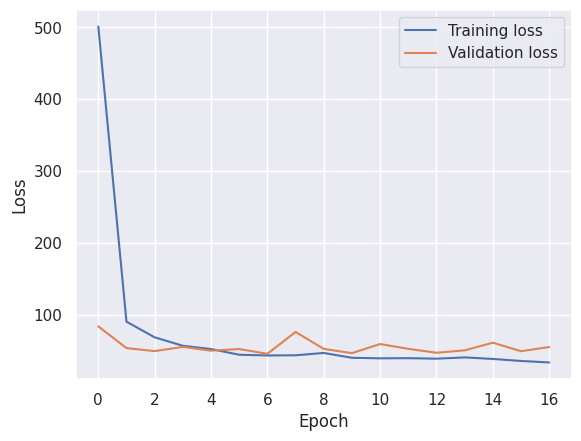

In [41]:
# Plot loss curve
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
def submission(pred, test_df, filename):
    """
    Creates a submission file for a prediction.

    Args:
        pred (np.ndarray): The predictions.
        test_df (pd.DataFrame): The test dataframe.
        filename (str): The filename of the submission file (must include .csv extension).

    Returns:
        pd.DataFrame: The submission dataframe.
    """
    # Ensure pred is a 1D array and has the same length as test_df
    pred = pred.reshape(-1)  # Flatten if necessary
    pred = pred[:len(test_df)]  # Truncate to match test_df length

    # Create the submission DataFrame
    df = pd.DataFrame({'House ID': test_df['House ID'], 'Price': pred})

    # Save the DataFrame to a CSV file
    df_n = df.to_csv(filename, index=False)

    # Return the DataFrame (optional)
    return df_n

In [43]:
# Select the features needed for the model
features = ['Bedrooms', 'Bathrooms', 'Area', 'Latitude', 'Longitude']

# Create separate input tensors for each feature
input_tensors = [tf.constant(test_numeriek_df[feature].values, dtype=tf.float32)[:, tf.newaxis]
                 for feature in features]

# Predict using the separate input tensors
y_pred = model_eng.predict(input_tensors)

# submission(y_pred, test_numeriek_df, 'submission_multimodeltest.csv')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [44]:
# Select the features needed for the model
features = ['Bedrooms', 'Bathrooms', 'Area', 'Latitude', 'Longitude']

# Prepare tabular data for prediction
X_test_tabular = [tf.constant(test_numeriek_df[feature].values, dtype=tf.float32)[:, tf.newaxis]
                   for feature in features]

# Load and preprocess images for prediction
test_image_rgb = np.array(test_numeriek_df['House ID'].apply(
    lambda x: load_image_as_array(x, img_test_directory, target_size=(64, 64), mode='RGB')).tolist()).astype('float32') / 255.0

test_image_gray = np.array(test_numeriek_df['House ID'].apply(
    lambda x: load_image_as_array(x, img_test_directory, target_size=(64, 64), mode='L')).tolist()).astype('float32') / 255.0


# Predict using the separate input tensors, including image data
y_pred = multimodel.predict([X_test_tabular, test_image_rgb, test_image_gray])

submission(y_pred, test_numeriek_df, 'submission_multimodeltest1.csv')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


### Convolutioneel neuraal netwerk from scratch

### Transfer learning

### Multimodaal mode

## Results

### Overview

### Scores

## Conclusion & Advice

## Sources